In [1]:
import copy
import sys
import time

import numpy as np
import pandas as pd
import sklearn.preprocessing

sys.path.append("..")
from helpers import filename_for

In [2]:
import tensorflow
from tensorflow import keras

print("tensorflow", tensorflow.__version__)
print("keras", keras.__version__)

tensorflow 2.1.0
keras 2.2.4-tf


In [3]:
class DataGeneratorBars(keras.utils.Sequence):
    def __init__(self, config):
        self.c = config

        self.labels = []
        self.featuresTri = []
        self.featuresBars = []

        self.scaler_tri = sklearn.preprocessing.MaxAbsScaler()
        self.scaler_e = sklearn.preprocessing.MaxAbsScaler()
        self.scaler_t = sklearn.preprocessing.MaxAbsScaler()

        file = filename_for(
            self.c["distance"],
            self.c["doubleplane"],
            self.c["energy"],
            self.c["erel"],
            self.c["neutrons"][0],
            "inclxx",
            self.c["subruns"][0],
            "bars.parquet",
        )
        data = pd.read_parquet(file)
        rows = len(data.index)
        del data

        self.batches_per_subrun = (rows * len(self.c["neutrons"])) // self.c["batch_size"]
        self.batches_per_cache = self.batches_per_subrun * self.c["subrun_cache_size"]
        self.len = self.batches_per_subrun * len(self.c["subruns"])

        self.cache_subruns = [
            self.c["subruns"][i : i + self.c["subrun_cache_size"]]
            for i in range(0, len(self.c["subruns"]), self.c["subrun_cache_size"])
        ]
        self.current_cache = -1

        print(f"Rows in one file: {rows}")
        print(f"{self.batches_per_subrun} batches per subrun")
        print(f"{self.len} total batches in {self.cache_subruns} caches")

        self.fitscalers()
        self.load(0)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        cacheid = index // self.batches_per_cache
        i = index % (self.batches_per_cache)
        # print(f"{index} -> c{cacheid}-i{i}")

        if cacheid != self.current_cache:
            self.load(cacheid)

        a = i * self.c["batch_size"]
        b = (i + 1) * self.c["batch_size"]

        tri = self.featuresTri[a:b]
        bars = self.featuresBars[a:b]
        x = bars  # [tri, bars]
        y = self.labels[a:b]
        return x, y, [None]

    def load(self, cacheid):
        subruns = self.cache_subruns[cacheid]
        print(f"Loading subruns {subruns} for cache {cacheid}")

        files = [
            filename_for(
                self.c["distance"],
                self.c["doubleplane"],
                self.c["energy"],
                self.c["erel"],
                n,
                "inclxx",
                subrun,
                "bars.parquet",
            )
            for n in self.c["neutrons"]
            for subrun in subruns
        ]
        data = pd.concat([pd.read_parquet(file) for file in files], ignore_index=True).sample(frac=1)
        data.loc[data["nHits"] == 0, self.c["label"]] = 0

        self.current_cache = cacheid
        self.featuresTri = self.scaler_tri.transform(data[self.c["cols_tri"]])
        self.featuresBars = np.dstack(
            (
                self.scaler_e.transform(data[self.c["cols_e"]].values.reshape(-1, 1)).reshape(
                    -1, len(self.c["cols_e"])
                ),
                self.scaler_t.transform(data[self.c["cols_t"]].values.reshape(-1, 1)).reshape(
                    -1, len(self.c["cols_t"])
                ),
            )
        ).reshape(-1, 60, 50, 2)
        self.labels = keras.utils.to_categorical(
            data[[self.c["label"]]].values.ravel(), num_classes=len(self.c["neutrons"]) + 1
        )
        del data

    def fitscalers(self):
        subruns = range(5)  # self.cache_subruns[0]
        files = [
            filename_for(
                self.c["distance"],
                self.c["doubleplane"],
                self.c["energy"],
                self.c["erel"],
                n,
                "inclxx",
                subrun,
                "bars.parquet",
            )
            for n in self.c["neutrons"]
            for subrun in subruns
        ]
        data = pd.concat([pd.read_parquet(file) for file in files], ignore_index=True)
        self.scaler_tri.fit(data[self.c["cols_tri"]])
        self.scaler_e.fit(data[self.c["cols_e"]].values.reshape(-1, 1))
        self.scaler_t.fit(data[self.c["cols_t"]].values.reshape(-1, 1))
        del data

In [4]:
config = {
    "distance": 15,
    "doubleplane": 30,
    "energy": 600,
    "erel": 500,
    "neutrons": [1, 2, 3, 4],
    "subruns": range(7),  # range(19),
    "subrun_cache_size": 7,
    "batch_size": 200,
    "cols_tri": ["nHits", "nClus", "Edep"],
    "cols_e": [str(i) for i in range(0, 30 * 100 * 2, 2)],
    "cols_t": [str(i + 1) for i in range(0, 30 * 100 * 2, 2)],
    "label": "nPN",
}

validation_config = config.copy()
validation_config["subruns"] = [19]

In [5]:
generator = DataGeneratorBars(config)
validation_generator = DataGeneratorBars(validation_config)

Rows in one file: 10000
200 batches per subrun
1400 total batches in [range(0, 7)] caches
Loading subruns range(0, 7) for cache 0
Rows in one file: 10000
200 batches per subrun
200 total batches in [[19]] caches
Loading subruns [19] for cache 0


In [34]:
from tensorflow.keras.layers import (
    Activation,
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    Input,
    MaxPooling2D,
    concatenate,
)
from tensorflow.keras.models import Model

# define two sets of inputs
# inputTri = Input(shape=(3,))
inputBars = Input(shape=(60, 50, 2))

# # the first branch operates on the first input
# t = Dense(40, activation="relu")(inputTri)
# t = Dense(5, activation="relu")(t)
# t = Model(inputs=inputTri, outputs=t)

# # the second branch opreates on the second input
# b = Conv2D(200, (3,3))(inputBars)
# #b = Dense(1000, activation="relu")(inputBars)
# b = Dense(10000, activation="relu")(b)
# #b = Dense(250, activation="relu")(b)
# b = Model(inputs=inputBars, outputs=b)

# # CONV => RELU => BN => POOL
# x = Conv2D(16, (3, 1), padding="valid", activation="relu")(inputBars)
# #x = BatchNormalization(axis=-1)(x)
# #x = MaxPooling2D(pool_size=(2, 2))(x)

# # flatten the volume, then FC => RELU => BN => DROPOUT
# x = Flatten()(x)
# x = Dense(600, activation="relu")(x)
# x = BatchNormalization(axis=-1)(x)
# x = Dropout(0.5)(x)

# x = Dense(5)(x)
# x = Activation("relu")(x)

# # combine the output of the two branches
# combined = concatenate([t.output, x.output])
# # apply a FC layer and then a regression prediction on the
# # combined outputs
# z = Dense(50, activation="relu")(combined)
# # z = Dense(100, activation="relu")(z)
# z = Dense(len(config["neutrons"]) + 1, activation="softmax")(z)

x = inputBars
chanDim = -1
# loop over the number of filters
#for i, (f, s) in enumerate([(5, (3, 1)), (10, (3, 3)), ]): -> 0,67
#for i, (f, s) in enumerate([(3, (1, 5)), (3, (3, 3)), ]):


x = Conv2D(16, (1, 3), padding="same", activation="relu")(x)
print("c2d-1", x.shape)
#x = BatchNormalization(axis=chanDim)(x)
#x = Dropout(0.2)(x)
#x = MaxPooling2D(pool_size=(1, 5))(x)
print("mp2d-1", x.shape)

x = Conv2D(32, (5, 5), padding="same", activation="relu")(x)
print("c2d-2", x.shape)
#x = BatchNormalization(axis=chanDim)(x)
#x = Dropout(0.2)(x)
#x = MaxPooling2D(pool_size=(5, 5))(x)
#print("mp2d-2", x.shape)

x = Flatten()(x)
print("f", x.shape)
x = Dense(1000, activation="relu")(x)
print("d-1", x.shape)
x = Dense(100, activation="relu")(x)
print("d-2", x.shape)
# x = BatchNormalization(axis=chanDim)(x)

x = Dense(len(config["neutrons"]) + 1, activation="softmax")(x)
model = Model(inputBars, x)
# model = Model(inputs=[t.input, x.input], outputs=z)
loss = keras.losses.CategoricalCrossentropy()
model.compile(loss=loss, optimizer="adagrad", metrics=["accuracy"])

c2d-1 (None, 60, 50, 16)
mp2d-1 (None, 60, 50, 16)
c2d-2 (None, 60, 50, 32)
f (None, 96000)
d-1 (None, 1000)
d-2 (None, 100)


In [35]:
history = model.fit(generator, verbose=2, epochs=20, shuffle=False, validation_data=validation_generator)

Train for 1400 steps, validate for 200 steps
Epoch 1/20
1400/1400 - 132s - loss: 0.8434 - accuracy: 0.6193 - val_loss: 0.7765 - val_accuracy: 0.6474
Epoch 2/20
1400/1400 - 128s - loss: 0.7621 - accuracy: 0.6506 - val_loss: 0.7443 - val_accuracy: 0.6706
Epoch 3/20
1400/1400 - 127s - loss: 0.7343 - accuracy: 0.6697 - val_loss: 0.7240 - val_accuracy: 0.6781
Epoch 4/20
1400/1400 - 127s - loss: 0.7162 - accuracy: 0.6799 - val_loss: 0.7101 - val_accuracy: 0.6848
Epoch 5/20
1400/1400 - 128s - loss: 0.7035 - accuracy: 0.6865 - val_loss: 0.7010 - val_accuracy: 0.6877
Epoch 6/20
1400/1400 - 128s - loss: 0.6959 - accuracy: 0.6900 - val_loss: 0.6948 - val_accuracy: 0.6888
Epoch 7/20
1400/1400 - 128s - loss: 0.6890 - accuracy: 0.6936 - val_loss: 0.6906 - val_accuracy: 0.6903
Epoch 8/20
1400/1400 - 129s - loss: 0.6840 - accuracy: 0.6960 - val_loss: 0.6867 - val_accuracy: 0.6925
Epoch 9/20
1400/1400 - 130s - loss: 0.6804 - accuracy: 0.6976 - val_loss: 0.6841 - val_accuracy: 0.6932
Epoch 10/20
1400/14

In [36]:
del generator
del validation_generator

In [37]:
test_config = config.copy()
test_config["subruns"] = range(7, 11)
test_generator = DataGeneratorBars(test_config)

Rows in one file: 10000
200 batches per subrun
800 total batches in [range(7, 11)] caches
Loading subruns range(7, 11) for cache 0


In [38]:
#X = [test_generator.featuresTri, test_generator.featuresBars]
X = test_generator.featuresBars
y_true = np.argmax(test_generator.labels, axis=1)
y_pred = np.argmax(model.predict(X), axis=1)

In [39]:
from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix,
    plot_confusion_matrix,
)

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

bac = balanced_accuracy_score(y_true, y_pred)
print(bac)
cm = confusion_matrix(y_true, y_pred, labels=range(0, len(config["neutrons"]) + 1))
print(cm)
cmrel = confusion_matrix(y_true, y_pred, labels=range(0, len(config["neutrons"]) + 1), normalize="true")
print((cmrel * 100).round())

0.7618492004615132
[[ 2086     0     0     0     0]
 [  523 35655  1822    15    11]
 [   64  8367 26864  4573    24]
 [    4  1155 10495 21937  6405]
 [    0   126  2232 11654 25988]]
[[100.   0.   0.   0.   0.]
 [  1.  94.   5.   0.   0.]
 [  0.  21.  67.  11.   0.]
 [  0.   3.  26.  55.  16.]
 [  0.   0.   6.  29.  65.]]


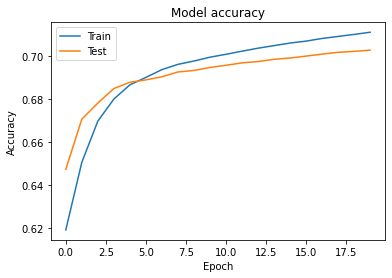

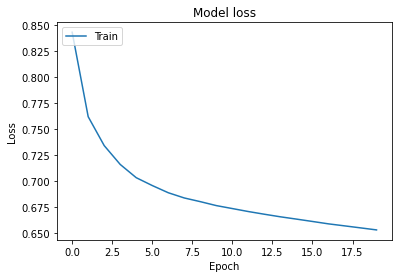

In [40]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

# Plot training & validation loss values
plt.plot(history.history["loss"])
# plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()